# Make dataset

In [39]:
import numpy as np
import jax.numpy as jnp
from jax import random
from utils import topk_binary_matrix

key = random.PRNGKey(0)
n = 100
d = 50
m = 10
k = 5
sparsity_list = [1, 3, 5]
svd_prec = 1e-8

In [40]:
N_train = 200
N_test  = 100
N_all   = N_train + N_test
N_trial = 30

idx_mat = random.permutation(key, jnp.tile(jnp.arange(N_all), [N_trial, 1]), axis = 1, independent=True)
idx_mat_train = idx_mat[:, :N_train]
idx_mat_test  = idx_mat[:, N_train:]

Lk, Rk = random.uniform(key, [n, k], minval=0, maxval=1), random.uniform(key, [k, d], minval=0, maxval=1)
Ak = Lk @ Rk
As = Ak + .1*random.normal(key, [N_all, n, d])
As /= jnp.outer(jnp.linalg.norm(As, ord="fro", axis=(1,2)), jnp.ones([n, d])).reshape(As.shape)

In [41]:
np.savez('data/input', 
        As=As, 
        n=n,
        d=d,
        m=m,
        k=k,
        sparsity_list=sparsity_list,
        svd_prec=svd_prec
        )
np.savez('data/setting',
        idx_mat_train=idx_mat_train,
        idx_mat_test=idx_mat_test,
        N_train=N_train,
        N_test=N_test, 
        N_all=N_all,  
        N_trial=N_trial
        )       

## Make S0 and S_init

In [42]:
for s in sparsity_list:
    S0 = topk_binary_matrix(random.normal(key, [m, n]), s)
    S_init = jnp.where(random.bernoulli(key, .5, [m, n]), 1.0, -1.0) * S0
    S_init /= jnp.linalg.norm(S_init, ord="fro")
    np.savez('data/params_s{}'.format(s),
        s=s,
        S0=S0,
        S_init=S_init
        )

# Load data

In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import grad
from utils import topk_binary_matrix, svd_trnc, scw

input_data = np.load("data/input.npz")
setting = np.load("data/setting.npz")

As = input_data["As"] 
n = input_data["n"]
d = input_data["d"]
m = input_data["m"]
k = input_data["k"]
sparsity_list = input_data["sparsity_list"]
svd_prec = input_data["svd_prec"]

idx_mat_train = setting["idx_mat_train"]
idx_mat_test = setting["idx_mat_test"]
N_train = setting["N_train"]
N_test = setting["N_test"]
N_all = setting["N_all"]
N_trial = setting["N_trial"]

def loss(S, U, Uk):
    return jnp.linalg.norm(Uk.T@(S.T@S)@U - jnp.concatenate([jnp.eye(k), jnp.zeros([k, d-k])], axis=1), ord='fro')**2 

grad_fn = grad(loss, argnums=0)

# Run experiment

In [24]:
import time

from numpy import average

s_list = []
t_list = []
idx_list = []
type_list = []
loss_list = []
error_list = []

time_dic = {"Dense":[], "Learn":[], "Fix":[]}

for s in sparsity_list:
    sol_dic = {}
    params = np.load("data/params_s{}.npz".format(s))
    S0 = params["S0"]
    S_init = params["S_init"]
    for i in range(3): #range(N_trial):
        train_idx_list = idx_mat_train[i]
        for method in ["Dense", "Learn", "Fix"]:
            start = time.time()
            S = S_init.copy()        
            S_prev = S_init.copy()
            for t in range(len(train_idx_list)):
                A = As[train_idx_list[t]]
                U, svals, Vh = svd_trnc(A, svd_prec)
                Uk = U[:,:k]
                
                Sd = -.1*grad_fn(S, U, Uk)
                S_prev = S
                S += Sd
                if method == "Learn":
                    S *= topk_binary_matrix(S, s)
                elif method == "Fix":
                    S *= S0 

            elapse = time.time() - start
            time_dic[method].append(elapse)
            print(method, elapse, average(time_dic[method]))
            sol_dic[(method, i)] = np.array(S)
    #np.save("result/sol_dic_s{}".format(s), sol_dic)

#df = pd.DataFrame(list(zip(s_list, t_list, idx_list, np.array(loss_list), np.array(error_list), type_list)), columns=["s", "t", "idx", "loss", "error", "method"])
#df.to_pickle("result/train_log.pkl")

Dense 1.8056490421295166 1.8056490421295166
Learn 2.0248570442199707 2.0248570442199707
Fix 1.8000819683074951 1.8000819683074951
Dense 1.9591889381408691 1.8824189901351929
Learn 1.5973801612854004 1.8111186027526855
Fix 1.8437650203704834 1.8219234943389893
Dense 1.8355379104614258 1.8667919635772705
Learn 1.8176040649414062 1.813280423482259
Fix 1.3886420726776123 1.677496353785197
Dense 1.3774549961090088 1.744457721710205
Learn 1.5435211658477783 1.745840609073639
Fix 1.307938814163208 1.5851069688796997
Dense 1.3523247241973877 1.6660311222076416
Learn 1.54490327835083 1.705653142929077
Fix 1.7700307369232178 1.6220917224884033
Dense 1.3704371452331543 1.6167654593785603
Learn 1.7504870891571045 1.713125467300415
Fix 1.497770071029663 1.60137144724528
Dense 1.608889102935791 1.6156402656010218
Learn 1.7173349857330322 1.7137268270765031
Fix 1.4134330749511719 1.5745231083461217
Dense 1.6297600269317627 1.6174052357673645
Learn 1.9123549461364746 1.7385553419589996
Fix 1.547883987

## Compute test errors

In [17]:
test_error_list = []
type_list = []
idx_list = []
s_list = []

for s in sparsity_list:
    sol_dic = np.load("result/sol_dic_s{}.npy".format(s), allow_pickle=True).item()
    for method in ["Dense", "Learn", "Fix"]:    
        for i in range(N_trial):
            S = sol_dic[(method, i)]
            test_error = np.average(np.array([jnp.linalg.norm(As[idx] - scw(S, As[idx], k, svd_prec), ord='fro')**2 for idx in idx_mat_test[i]]))
            test_error_list.append(test_error)
            type_list.append(method)
            idx_list.append(i)
            s_list.append(s)
        
df = pd.DataFrame(list(zip(s_list, idx_list, np.array(test_error_list), type_list)), columns=["s", "idx", "error", "method"])
#df.to_pickle("result/test_error.pkl")

# Analysis

In [18]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['ps.useafm']=True
matplotlib.rcParams['pdf.use14corefonts']=True
matplotlib.rcParams['text.usetex']=True
import seaborn as sns
sns.set(font_scale = 1.8)
import numpy as np
import pandas as pd
import jax.numpy as jnp
import itertools

<Figure size 432x288 with 0 Axes>

<Figure size 432x259.2 with 0 Axes>

<Figure size 432x259.2 with 0 Axes>

<Figure size 432x259.2 with 0 Axes>

<Figure size 432x259.2 with 0 Axes>

<Figure size 432x259.2 with 0 Axes>

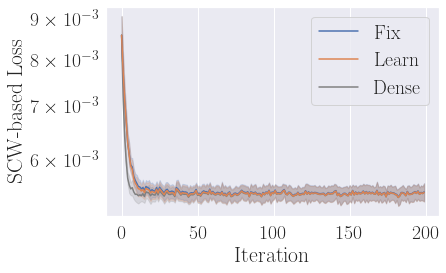

In [25]:
df = pd.read_pickle("result/train_log.pkl")
sparsity_list = df.loc[:,"s"].unique()

for ys in list(itertools.product(["loss", "error"], sparsity_list)):
    plt.clf()
    plt.figure(figsize=(6,3.6)) 
    dfs = df[df["s"]==ys[1]] 
    ax = sns.lineplot(data=dfs, x="t", y=ys[0], hue="method", hue_order=["Dense", "Fix", "Learn"], palette=["gray", "C0", "C1"], ci="sd")
    ax.set(yscale="log")
    handles, labels = ax.get_legend_handles_labels()
    labels = [r'\rm Fix', r'\rm Learn', r'\rm Dense']
    handles = [handles[1], handles[2], handles[0]]
    if ys == ('loss', 1):
        ax.legend(handles=handles, labels=labels, loc = 'center right', ncol=1)
    else:
        ax.legend(handles=handles, labels=labels, loc = 'upper right', ncol=1)
    ax.set_xlabel(r"\rm Iteration")
    ylabel = r"\rm Surrogate Loss" if ys[0] == "loss" else r"\rm SCW-based Loss"
    ax.set_ylabel(ylabel)
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    plt.savefig('fig/train_{}_s{}.pdf'.format(ys[0], ys[1]), bbox_inches="tight")

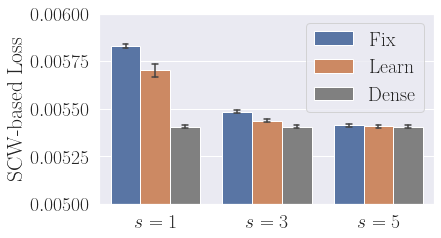

In [29]:
plt.figure(figsize=(6,3.5)) 
df = pd.read_pickle("result/test_error.pkl")

plt.ylim([.005, .006])
ax = sns.barplot(x="s", y="error", data=df.loc[:, ["s", "error", "method"]], errwidth=1.5, capsize=.05, hue="method", hue_order=["Fix", "Learn", "Dense"], palette=["C0", "C1", "gray"], ci="sd")
handles, labels = ax.get_legend_handles_labels()
labels = [r'\rm Fix', r'\rm Learn', r'\rm Dense']
ax.legend(handles=handles, labels=labels, loc = 'upper right', ncol=1)
ax.set_ylabel(r"\rm SCW-based Loss")
ax.set_xlabel("")
ax.set_xticklabels([r'$s={}$'.format(int(s)) for s in sparsity_list])
plt.savefig('fig/test.pdf', bbox_inches="tight")